In [92]:
%matplotlib inline
import os
from scipy.spatial import distance
os.chdir('/vco260/')

# collaborative filtering implemenation
1. the purpose of this notebook is to train a collaborative filtering models(different batch sizes and learning rates) on the uniprot id and go term id

### get_uniprot_colab_data function:
#### works on load raw gene data which merges ALL dataframes
##### loads cached result if not redo
1. column name - select column for collaborative filtering with the uniprot id ('go',pubmeb id, 
2. cut_off_col_per_idx - for go terms and uniprot id means at least x go terms per uniprot id(x=2 by default)
3. cut_off_idx_per_col - filter out go terms with less the x uniprot id related to them(x=2 by default)
4. redo - merges again using chosen column and new filter cut offs (does not redownload data)



In [93]:
from src.gene_collaborative_filtering import *
pd.options.display.max_colwidth=200

In [94]:
min_gene_per_go=5
min_go_per_gene = 2
df,codes=get_uniprot_colab_data('go',cut_off_col_per_idx=min_go_per_gene,cut_off_idx_per_col=min_gene_per_go,redo=False)
df=df.drop_duplicates()

/vco260/src/dataprocess.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  temp[feature]=temp[feature].astype(str).str.lstrip().str.rstrip()
/vco260/src/dataprocess.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  temp[feature]=temp[feature].str.split(split_on)
100%|██████████| 2/2 [00:00<00:00,  8.12it/s]


In [97]:
train_data=pd.read_parquet('data/train_data.parquet')
test_data=pd.read_parquet('data/test_data.parquet')
train_data=train_data[['Entry_categorical','go_categorical','target']]
test_data=test_data[['Entry_categorical','go_categorical','target']]
mydf=pd.read_csv('results/my_embedding_result2019_02_11.csv')
codes=load_from_pickle('data/codes.codes')
mydf['Entry']=[codes[0][x] for x in tqdm(mydf['Entry_int'].values.tolist())]
myarray=mydf.values[:,:300]

100%|██████████| 117126/117126 [00:00<00:00, 1136830.68it/s]


In [98]:
merged=pd.read_parquet(load_raw_gene_data())
merged=merged.drop_duplicates(subset=['Entry'])
merged.index=merged.Entry

In [99]:
def intersection_union(ent_cat1,ent_cat2):
    one_ent=df[df.Entry_categorical==ent_cat1]['go_categorical'].values.tolist()
    two_ent=df[df.Entry_categorical==ent_cat2]['go_categorical'].values.tolist()
    return len(set(one_ent).intersection(set(two_ent)))/len(set(one_ent).union(set(two_ent)))

def entry_to_code(entry):
    return list(codes[0]).index(entry)

def nearest(entry,num_of=5,metric='euclidean',max_dis=''):
    dis_res=distance.cdist(myarray, mydf[mydf.Entry==entry].values[:,0:300],metric)
    dis_res=np.array([x[0] for x in dis_res])
    if max_dis!='':
        closest_ind=np.where(dis_res<max_dis)[0]
    else :closest_ind=dis_res.argsort()[:num_of]
    entries=mydf.iloc[closest_ind]['Entry'].values.tolist()
    entries_int=mydf.iloc[closest_ind]['Entry_int'].values.tolist()
    tempdf=merged.loc[entries][['go']]
    tempdf['distance']=dis_res[[closest_ind]]
    entry_cat=entry_to_code(entry)
    tempdf['inter']=[intersection_union(entry_cat,x) for x in entries_int]
    return tempdf[['distance','go','inter']]


metricses=[ 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation',
    'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'jensenshannon',
    'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto',
    'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean',
    'wminkowski', 'yule']

In [226]:
res_corr=[]
for j in tqdm(range(10)):
    for q in [50,500,5000]:
        ent=mydf.Entry.sample(1).values[0]
        #print(ent)
        res=nearest(ent,metric='euclidean',num_of=q)
        # #res[['distance','inter']].corr()
        res2=res[['distance','inter']].corr()
        res_corr.append({'num_of':q,'corr':res2['inter'].values[0]})
        #res2['inter'].values[0]


100%|██████████| 10/10 [02:27<00:00, 14.75s/it]


In [227]:
dftemp=pd.DataFrame(res_corr)

In [228]:
dftemp.groupby('num_of').mean()

corr
num_of          
50     -0.412962
500    -0.038577
5000   -0.008618

In [69]:
ents=mydf.Entry.sample(100).values.tolist()
def distance_entries(ent_int1,ent_int2,metric='cosine'):
    return distance.cdist(mydf[mydf.Entry_int==ent_int1].values[:,0:300], mydf[mydf.Entry_int==ent_int2].values[:,0:300],metric)[0][0]

In [70]:
def distance_and_inter(ent_int1,ent_int2,metric='cosine'):
    return {'x':distance_entries(ent_int1,ent_int2,
                                 metric=metric),'y':intersection_union(ent_int1,ent_int2)}
    

# calculate correlation between distance in embedding space and ratio of related go terms

In [84]:

import itertools
res=[]
for x in tqdm(list(itertools.combinations(mydf.Entry_int.sample(300).values.tolist(),2))):
    res.append(distance_and_inter(x[0],x[1],metric='cosine'))

100%|██████████| 44850/44850 [02:31<00:00, 296.67it/s]


In [87]:
pd.DataFrame(res)

x         y
0      6.927343e-08  0.000000
1      1.372431e-08  0.000000
2      4.190082e-08  0.000000
3      1.621788e-08  0.000000
4      2.524040e-08  0.000000
5      1.768381e-08  0.000000
6      2.962147e-08  0.000000
7      9.683561e-07  0.000000
8      1.869526e-08  0.000000
9      7.725715e-08  0.000000
10     2.422266e-08  0.000000
11     1.020683e-06  0.000000
12     1.678336e-08  0.000000
13     1.040398e-07  0.000000
14     1.858726e-08  0.000000
15     1.792429e-08  0.000000
16     1.159478e-07  0.000000
17     1.878002e-08  0.000000
18     3.668717e-08  0.000000
19     2.097541e-08  0.000000
20     7.195791e-08  0.000000
21     2.140733e-07  0.000000
22     2.150866e-07  0.000000
23     5.763405e-08  0.000000
24     1.449520e-08  0.000000
25     2.863358e-08  0.000000
26     3.759857e-06  0.000000
27     2.228212e-08  0.000000
28     3.254750e-08  0.000000
29     1.654448e-07  0.000000
...             ...       ...
44820  3.060108e-06  0.111111
44821  7.748857e-09  0.000000
44822  5.067560e-07  0.000000
44823  5.371280e-07  0.500000
44824  5.249780e-07  0.166667
44825  5.123713e-07  0.000000
44826  5.193739e-07  0.000000
44827  3.934087e-06  0.111111
44828  5.496087e-07  0.000000
44829  5.817829e-09  0.000000
44830  7.209883e-09  0.000000
44831  1.973538e-08  0.000000
44832  5.120375e-09  0.000000
44833  3.041763e-06  0.000000
44834  1.167743e-08  0.000000
44835  4.286526e-09  0.166667
44836  2.047718e-08  0.000000
44837  3.085084e-09  0.000000
44838  3.040882e-06  0.111111
44839  7.658671e-09  0.000000
44840  2.299118e-08  0.142857
44841  5.106984e-09  0.142857
44842  3.059207e-06  0.000000
44843  1.161884e-08  0.000000
44844  1.984599e-08  0.000000
44845  3.236631e-06  0.000000
44846  2.959166e-08  0.000000
44847  3.091101e-06  0.000000
44848  8.030044e-09  0.000000
44849  3.018401e-06  0.083333

[44850 rows x 2 columns]

In [88]:
df=pd.DataFrame(res)

In [91]:
df.sort_values('x',ascending=False)

x     y
40422  8.308280e-05  0.00
40398  8.121301e-05  0.00
41633  7.168008e-05  0.00
15366  7.119960e-05  0.00
41632  6.274344e-05  0.00
17741  6.158564e-05  0.00
41642  5.736805e-05  0.00
31875  5.729508e-05  0.00
7913   5.718271e-05  0.00
40394  5.601992e-05  0.00
40431  5.576209e-05  0.00
2574   5.413569e-05  0.00
40421  5.409148e-05  0.00
7899   5.380257e-05  0.00
36123  5.338811e-05  0.00
41650  5.303418e-05  0.00
41448  5.193135e-05  0.00
24063  5.162748e-05  0.00
35858  5.153409e-05  0.00
31889  5.076360e-05  0.00
41682  5.061929e-05  0.00
9775   5.055969e-05  0.00
41673  5.055044e-05  0.00
25854  5.046111e-05  0.00
34473  5.045563e-05  0.00
9244   5.042062e-05  0.00
41610  5.033729e-05  0.00
41636  5.033356e-05  0.00
40491  5.027061e-05  0.00
3153   5.025946e-05  0.00
...             ...   ...
10738  2.737814e-09  0.00
12020  2.686451e-09  0.00
646    2.655128e-09  0.50
18248  2.633519e-09  0.00
883    2.612211e-09  0.25
14440  2.612079e-09  0.00
26962  2.608635e-09  0.00
37472  2.603141e-09  0.00
13968  2.576891e-09  0.00
13726  2.561495e-09  0.00
12059  2.548708e-09  0.00
37962  2.545267e-09  0.00
35659  2.544614e-09  0.25
18256  2.492507e-09  0.00
14458  2.492099e-09  0.25
38058  2.450110e-09  0.00
14463  2.439646e-09  0.20
13742  2.401285e-09  0.00
12181  2.394481e-09  0.20
18276  2.274633e-09  0.00
18060  2.252069e-09  0.00
12088  2.240930e-09  0.00
38053  2.172244e-09  0.00
13749  2.122882e-09  0.20
12199  2.045638e-09  0.00
11960  2.014849e-09  0.20
11978  1.928328e-09  0.00
11985  1.910962e-09  0.00
44799  1.743076e-09  0.25
19752  1.542519e-09  0.20

[44850 rows x 2 columns]

Text(0.5, 0, 'distance')

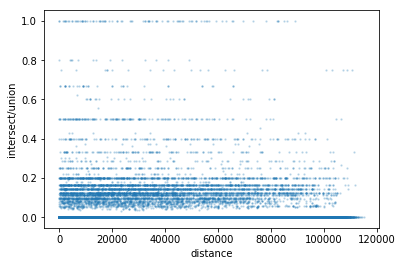

In [75]:
plt.scatter(df['x'],df['y'],s=2,alpha=0.2)
plt.ylabel('intersect/union')
plt.xlabel('distance')

Text(0, 0.5, 'distance')

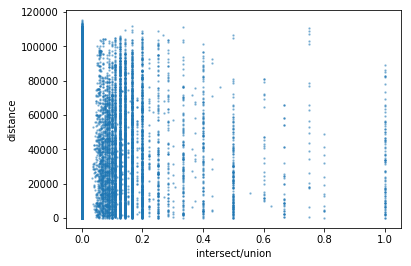

In [76]:
plt.scatter(df['y'],df['x'],s=2,alpha=0.4)
plt.xlabel('intersect/union')
plt.ylabel('distance')